In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

####
### 1a) les inn og forstå dataene

In [117]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

df = pd.read_csv(url)

df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]

In [118]:
df_select = df[["id", "name", "sex", "age_cat", "race", "two_year_recid", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "is_recid", "is_violent_recid", "v_decile_score", "score_text", "days_b_screening_arrest"]]

# fjerner alle som ikke ble vurdert innen 30 dager forut/i 


### Kolonnenes betydning

- **id** kandidatens id.

- **name** kandidatens navn.

- **sex** kandidatens kjønn.

- **age_cat** alderskategori; mindre enn 25, mellom 25 og 45, over 45.

- **race** etnisitet.

- **two_year_recid** hvorvidt kandidaten begikk et nytt lovbrudd innen to år etter løslatelse.

- **juv_fel_count** antall ungdomsforbrytelser.

- **juv_misd_count** antall ungdomsforseelser.

- **priors_count** antall tidligere forbrytelser.

- **c_charge_degree**



- Hvor ofte ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert til å begå straffbare handlinger i framtiden (som andel, ikke totalt antall):

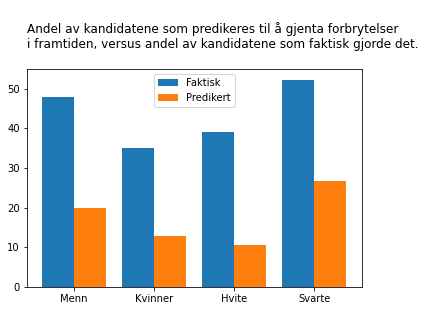

In [119]:
# Velger ut undergrupper for menn, kvinner, hvite og svarte
df_male = df_select[df_select["sex"] == "Male"]
df_female = df_select[df_select["sex"] == "Female"]
df_white = df_select[df_select["race"] == "Caucasian"]
df_black = df_select[df_select["race"] == "African-American"]


# prosent av gruppen som begår en forbrytelse på nytt innen to år
male_recid = len(df_male[df_male["two_year_recid"]==1].index) / len(df_male.index)*100
female_recid = len(df_female[df_female["two_year_recid"]==1].index) / len(df_female.index)*100
white_recid = len(df_white[df_white["two_year_recid"]==1].index) / len(df_white.index)*100
black_recid = len(df_black[df_black["two_year_recid"]==1].index) / len(df_black.index)*100


# velger nivå high som at de predikeres til å begå forbrytelese
male_pred = len(df_male[df_male["score_text"] == "High"].index) / len(df_male.index)*100
female_pred = len(df_female[df_female["score_text"] == "High"].index) / len(df_female.index)*100
white_pred = len(df_white[df_white["score_text"] == "High"].index) / len(df_white.index)*100
black_pred = len(df_black[df_black["score_text"] == "High"].index) / len(df_black.index)*100


labels = ["Menn", "Kvinner", "Hvite", "Svarte"]
x = np.arange(len(labels))

y1 =  [male_recid, female_recid, white_recid, black_recid]
y2 = [male_pred, female_pred, white_pred, black_pred]
width = 0.40

plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks(x, labels)
plt.legend(['Faktisk', 'Predikert'])
plt.title("\nAndel av kandidatene som predikeres til å gjenta forbrytelser \ni framtiden, versus andel av kandidatene som faktisk gjorde det.\n", loc = "left")
plt.show()

- Hvor ofte ulike grupper fikk ulike risikoskårer:

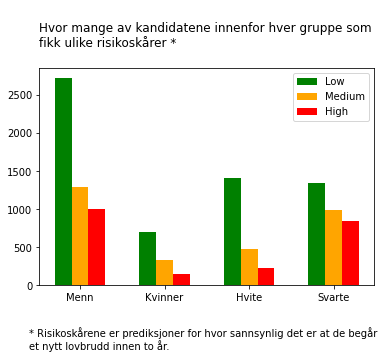

In [120]:
low = [len(df_male[df_male["score_text"] == "Low"].index),
       len(df_female[df_female["score_text"] == "Low"].index),
       len(df_white[df_white["score_text"] == "Low"].index),
       len(df_black[df_black["score_text"] == "Low"].index)]

medium = [len(df_male[df_male["score_text"] == "Medium"].index),
          len(df_female[df_female["score_text"] == "Medium"].index),
          len(df_white[df_white["score_text"] == "Medium"].index),
          len(df_black[df_black["score_text"] == "Medium"].index)]

high = [len(df_male[df_male["score_text"] == "High"].index),
       len(df_female[df_female["score_text"] == "High"].index),
       len(df_white[df_white["score_text"] == "High"].index),
       len(df_black[df_black["score_text"] == "High"].index)]


col_labs = ["Low", "Medium", "High", "h"]
x_labs = ["Menn", "Kvinner", "Hvite" ,"Svarte"]
x = np.arange(len(col_labs))
width = 0.20

# Plotter risikoskårene i grupper ved siden av hverandre
low = plt.bar(x-width, low, width, color='g')
medium = plt.bar(x, medium, width, color='orange')
high = plt.bar(x+width, high, width, color='r')

plt.xticks(x, x_labs)
plt.legend(col_labs)
plt.title("\nHvor mange av kandidatene innenfor hver gruppe som \nfikk ulike risikoskårer *\n", loc = "left")
plt.figtext(0.1, -0.1, "* Risikoskårene er prediksjoner for hvor sannsynlig det er at de begår \net nytt lovbrudd innen to år.", ha = "left")
plt.show()

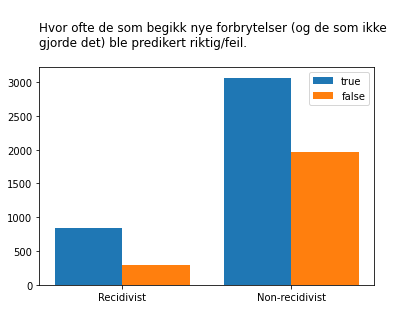

In [121]:
# Gold_pos er de som begikk nye lovbrudd innen to år
gold_pos = df_select[df_select["two_year_recid"] == 1]
gold_neg = df_select[df_select["two_year_recid"] == 0]

# True pos er de som begikk nye lovbrudd og ble predikert til å begå nye lovbrudd
true_pos = gold_pos[gold_pos["score_text"] == "High"]
false_pos = gold_neg[gold_neg["score_text"] == "High"]

true_neg = gold_neg[gold_neg["score_text"] == "Low"] + gold_neg[gold_neg["score_text"] == "Medium"]
false_neg = gold_pos[gold_pos["score_text"] == "Low"] + gold_pos[gold_pos["score_text"] == "Medium"]

col_labs = ["true", "false"]
x_labs = ["Recidivist", "Non-recidivist"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.20, [len(true_pos.index), len(true_neg.index)], width)
plt.bar(x+0.20, [len(false_pos.index), len(false_neg.index)], width)

plt.xticks(x, x_labs)
plt.title("\nHvor ofte de som begikk nye forbrytelser (og de som ikke \ngjorde det) ble predikert riktig/feil.\n", loc = "left")
plt.legend(col_labs)

#### 
#### 
- Hvordan de som begikk nye straffbare handlinger (og de som ikke gjorde det) fikk ulike risikoskårer - hvite versus svarte:

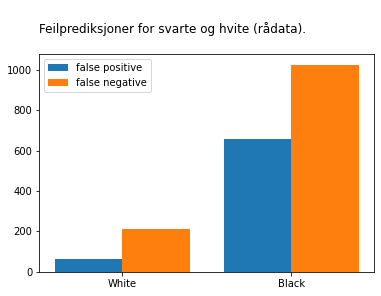

In [122]:
gold_pos_white = gold_pos[gold_pos["race"] == "Caucasian"]
gold_pos_black = gold_pos[gold_pos["race"] == "African-American"]
gold_neg_white = gold_neg[gold_neg["race"] == "Caucasian"]
gold_neg_black = gold_neg[gold_neg["race"] == "African-American"]

false_pos_white = gold_neg_white[gold_neg_white["score_text"] == "High"]
false_pos_black = gold_neg_black[gold_neg_black["score_text"] == "High"]

false_neg_white = gold_pos_white[gold_pos_white["score_text"] == "Low"] + gold_pos_white[gold_pos_white["score_text"] == "Medium"]
false_neg_black = gold_pos_black[gold_pos_black["score_text"] == "Low"] + gold_pos_black[gold_pos_black["score_text"] == "Medium"]

col_labs = ["false positive", "false negative"]
x_labs = ["White", "Black"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.2, [len(false_pos_white.index), len(false_neg_white.index)], width)
plt.bar(x+0.2, [len(false_pos_black.index), len(false_neg_black.index)], width)

plt.xticks(x, x_labs)
plt.title("\nFeilprediksjoner for svarte og hvite (rådata).\n", loc = "left")
plt.legend(col_labs)

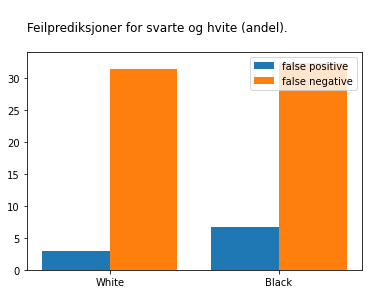

In [123]:
pos_white_ratio = len(false_pos_white.index) / len(df_white.index) * 100
pos_black_ratio = len(false_pos_black.index) / len(df_black.index) * 100
neg_white_ratio = len(false_neg_white.index) / len(df_white.index) * 100
neg_black_ratio = len(false_neg_black.index) / len(df_black.index) * 100

col_labs = ["false positive", "false negative"]
x_labs = ["White", "Black"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.2, [pos_white_ratio, pos_black_ratio], width)
plt.bar(x+0.2, [neg_white_ratio, neg_black_ratio], width)

plt.xticks(x, x_labs)
plt.title("\nFeilprediksjoner for svarte og hvite (andel).\n", loc = "left")
plt.legend(col_labs)

### 1 d)

In [124]:
# Velger ut data for å trene modeller, med og uten COMPAS-data
X_compas = df_select.drop(columns = ['id','name','two_year_recid', "is_violent_recid", "is_recid"])

#Vår modell med egenutvalgt input, uten COMPAS-summer
X_pure = X_compas.drop(columns = ["score_text", "v_decile_score"])

#Propublicas modell: Input brukt av Propublica for å predikere hva COMPAS-algoritmen sine prediksjoner
X_propublica = df[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]

#Definerer kategoriske of numeriske verdier for X_compas
categorical_cols_X_compas = ['sex', 'age_cat', 'race', "score_text"] # skal konverteres til kategoriske vha one-hot encoding
numerical_cols_X_compas = [el for el in X_compas.columns if el not in categorical_cols_X_compas] #skal konverteres til arrays av int

#Definerer kategoriske of numeriske verdier for X_pure
categorical_cols_X_pure = ['sex', 'age_cat', 'race']
numerical_cols_X_pure = [el for el in X_pure.columns if el not in categorical_cols_X_pure] #lager en liste av alle som ikke skal være kategoriske

#Definerer kategoriske of numeriske verdier for X_propublica
categorical_cols_propublica = ["age_cat", "race", "sex", "c_charge_degree"]
numerical_cols_X_propublica = [el for el in X_propublica.columns if el not in categorical_cols_propublica]

#Konverterer verdier til kategoriske vha one-hot-encoding
X_compas = pd.get_dummies(X_compas, columns=categorical_cols_X_compas, prefix=categorical_cols_X_compas, prefix_sep='_')
X_pure = pd.get_dummies(X_pure, columns=categorical_cols_X_pure, prefix=categorical_cols_X_pure, prefix_sep='_')
X_propublica = pd.get_dummies(X_propublica, columns=categorical_cols_propublica, prefix=categorical_cols_propublica, prefix_sep='_')

#Fjerner kolonnene tatt vekk i propublica
X_propublica = X_propublica.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

#Det som skal predikeres for pure og compas
Y = df_select[["two_year_recid"]]
Y = np.ravel(Y)
#Det som skal predikeres for propublica
Y_prop = df_select["score_text"] != "Low"

#konverterer numeriske verdier til numpy-array av int
for col in numerical_cols_X_compas:
    X_compas[col] = X_compas[[col]].to_numpy()

for col in numerical_cols_X_pure:
    X_pure[col] = X_pure[[col]].to_numpy()

for col in numerical_cols_X_propublica:
    X_propublica[col] = X_propublica[[col]].to_numpy()
    

In [125]:
#Model som predikerer uten COMPAS-data og model som predikerer utifra COMPAS

#logistisk regresjonsmodell

#Pure
Xp_train, Xp_test, Y_train, Y_test = train_test_split(X_pure, Y, test_size = 0.2, random_state = 0)
log_reg_pure = LogisticRegression(max_iter=1000)

log_reg_pure.fit(Xp_train, Y_train)

log_reg_pure.predict(Xp_train)
log_reg_pure.predict_proba(Xp_train)

#Compas
Xc_train, Xc_test, Y_train, Y_test = train_test_split(X_compas, Y, test_size = 0.2, random_state = 0)
log_reg_compas = LogisticRegression(max_iter=1000)

log_reg_compas.fit(Xc_train, Y_train)
weights_compas  = log_reg_compas.coef_

log_reg_compas.predict(Xc_train)
log_reg_compas.predict_proba(Xc_train)

#Propublica
Xprop_train, Xprop_test, Y_prop_train, Y_prop_test = train_test_split(X_propublica, Y_prop, test_size = 0.2, random_state = 0)
log_reg_propublica = LogisticRegression(max_iter=1000)

log_reg_propublica.fit(Xprop_train, Y_prop_train)

log_reg_propublica.predict(Xprop_train)
log_reg_propublica.predict_proba(Xprop_train)


# weight_highest = max(weights_compas[0])
# index_highest = np.where(weights_compas[0] == weight_highest)[0][0]
# param_highest = X_compas.columns[index_highest]

# print(param_highest)

# col_weights = {}

# for i, col in enumerate(X_compas.columns):
#     col_weights[col] = weights_compas[0][i]

# print(col_weights)
# print(col_weights["race_African-American"] / col_weights["race_Caucasian"])

array([[0.45062772, 0.54937228],
       [0.8483857 , 0.1516143 ],
       [0.45077215, 0.54922785],
       ...,
       [0.42695491, 0.57304509],
       [0.27571243, 0.72428757],
       [0.34295693, 0.65704307]])

In [126]:
#Tester treffsikkerheten til modellene 

#pure
print(log_reg_pure.score(Xp_test, Y_test))

#Propublica
print(log_reg_propublica.score(Xprop_test, Y_prop_test))

#Compas
print(log_reg_compas.score(Xc_test, Y_test))



0.6704453441295547
0.7336032388663968
0.6834008097165992


#### Confusion matrix for pure-modellen

In [127]:
#Lager confusion matrix for de ulike gruppene for pure-modellen

#Oppretter ordboken hvor verdiene skal lagres. Gruppe som nøkkel, kolonnenavnet i datasettet som verdi.
cm_per_gruppe = {'Hvite': "race_Caucasian" , 'Svarte': "race_African-American" , 'Menn': "sex_Male", 'Kvinner': "sex_Female"}

#Itererer gjennom ordboken, utfører operasjonene for hver nøkkel. 
for key in cm_per_gruppe.keys():

    #Deler opp kolonnenavnet, siden det ligger på formen (Kolonne): (Verdi) i datasettet, ikke kategorisk oppdeling med (kolonnenavn) : (1/0) slik som her. 
    #Henter deretter ut dataen som matcher gruppen. F.eks. alle med race_African-American == 1. (Alle som tilhører etnisiteten)
    filterVerdi = cm_per_gruppe[key].split("_")
    df_filtrert_paa_gruppe = df_select[df_select[filterVerdi[0]] == filterVerdi[1]]

    #Gjør en prediksjon på den utvalgte gruppen med modellen trent tidligere. Overskriver verdien til nøkkelen i ordboken og lagrer prediksjonsarrayet som verdi.
    #Henter ut prediksjonene fra COMPAS for gruppen og lagrer som et Y-array for sammenligning.
    #Oppretter en confusion matrix. Lagrer denne som nøkkelens nye verdi. 
    cm_per_gruppe[key] = ((log_reg_pure.predict(X_pure[X_pure[cm_per_gruppe[key]] == 1])))
    Y_cm = df_filtrert_paa_gruppe[["two_year_recid"]]
    Y_cm = np.ravel(Y_cm)
    tn, fp, fn, tp = confusion_matrix(Y_cm, cm_per_gruppe[key]).ravel()
    cm_per_gruppe[key] = {"tn": tn, "fp": fp, "fn": fn, "tp": tp}
    
#Oppretter confusion matrix for hele datasettet samlet. Lagrer som en egen nøkkel med verdi.
y_pred = log_reg_pure.predict(X_pure)

tn, fp, fn, tp = confusion_matrix(Y, y_pred).ravel()
cm_per_gruppe["Hele gruppen"] = {"tn": tn, "fp": fp, "fn": fn, "tp": tp}


#Itererer gjennom ordboken og skriver ut.
for key in cm_per_gruppe.keys():
    print(f"Antallet ekte positive for {key} er {cm_per_gruppe[key]['tp']}, antallet falske positive er {cm_per_gruppe[key]['fp']}, antallet ekte negative er {cm_per_gruppe[key]['tn']} og falske negative er {cm_per_gruppe[key]['fn']}.")
    

Antallet ekte positive for Hvite er 290, antallet falske positive er 157, antallet ekte negative er 1124 og falske negative er 532.
Antallet ekte positive for Svarte er 1149, antallet falske positive er 536, antallet ekte negative er 978 og falske negative er 512.
Antallet ekte positive for Menn er 1431, antallet falske positive er 708, antallet ekte negative er 1893 og falske negative er 965.
Antallet ekte positive for Kvinner er 103, antallet falske positive er 39, antallet ekte negative er 723 og falske negative er 310.
Antallet ekte positive for Hele gruppen er 1534, antallet falske positive er 747, antallet ekte negative er 2616 og falske negative er 1275.


#### Confusion matrix for datasettet (COMPAS' faktiske prediksjoner vs. utfallet)

In [162]:
cm_per_gruppe_for_datasett = {'Hvite': "race_Caucasian" , 'Svarte': "race_African-American" , 'Menn': "sex_Male", 'Kvinner': "sex_Female"}

def func (hoyrisk, lavrisk):
    hoyrisk_kat = np.full(len(hoyrisk), 1)
    lavrisk_kat = np.full(len(lavrisk), 0)

    recidivist_hoyrisk = hoyrisk["two_year_recid"]
    recidivist_lavrisk = lavrisk["two_year_recid"]

    xx, fp, yy, tp = confusion_matrix(recidivist_hoyrisk, hoyrisk_kat).ravel()
    tn, xx, fn, yy = confusion_matrix(recidivist_lavrisk, lavrisk_kat).ravel()

    ppv = posPredVerdi(hoyrisk)

    return {"tn": tn, "fp": fp, "fn": fn, "tp": tp, "ppv": ppv}


def posPredVerdi (hoyrisk):
    recidivist_hoyrisk = hoyrisk[hoyrisk["two_year_recid"]==1]
    return round((len(recidivist_hoyrisk) / len(hoyrisk)) * 100)



for key in cm_per_gruppe_for_datasett.keys():

    filterVerdi = cm_per_gruppe_for_datasett[key].split("_")
    df_filtrert_paa_gruppe = df_select[df_select[filterVerdi[0]] == filterVerdi[1]]

    hoyrisk = df_filtrert_paa_gruppe[df_filtrert_paa_gruppe["score_text"] != "Low"]
    lavrisk = df_filtrert_paa_gruppe[df_filtrert_paa_gruppe["score_text"] == "Low"]

    cm_per_gruppe_for_datasett[key] = func(hoyrisk, lavrisk)



hoyrisk = df_select[df_select["score_text"] != "Low"]
lavrisk = df_select[df_select["score_text"] == "Low"]
cm_per_gruppe_for_datasett["Hele Gruppen"] = func(hoyrisk, lavrisk)



for key in cm_per_gruppe_for_datasett.keys():
    print(f"Antallet sanne positive for {key} er {cm_per_gruppe_for_datasett[key]['tp']}, antallet falske positive er {cm_per_gruppe_for_datasett[key]['fp']}, antallet sanne negative er {cm_per_gruppe_for_datasett[key]['tn']}, falske negative er {cm_per_gruppe_for_datasett[key]['fn']} og positiv prediktiv verdi er {cm_per_gruppe_for_datasett[key]['ppv']}%.")


print(cm_per_gruppe_for_datasett)

Antallet sanne positive for Hvite er 414, antallet falske positive er 282, antallet sanne negative er 999, falske negative er 408 og positiv prediktiv verdi er 59%.
Antallet sanne positive for Svarte er 1188, antallet falske positive er 641, antallet sanne negative er 873, falske negative er 473 og positiv prediktiv verdi er 65%.
Antallet sanne positive for Menn er 1487, antallet falske positive er 788, antallet sanne negative er 1813, falske negative er 909 og positiv prediktiv verdi er 65%.
Antallet sanne positive for Kvinner er 246, antallet falske positive er 230, antallet sanne negative er 532, falske negative er 167 og positiv prediktiv verdi er 52%.
Antallet sanne positive for Hele Gruppen er 1733, antallet falske positive er 1018, antallet sanne negative er 2345, falske negative er 1076 og positiv prediktiv verdi er 63%.
{'Hvite': {'tn': 999, 'fp': 282, 'fn': 408, 'tp': 414, 'ppv': 59}, 'Svarte': {'tn': 873, 'fp': 641, 'fn': 473, 'tp': 1188, 'ppv': 65}, 'Menn': {'tn': 1813, 'fp

#### Partial dependence

In [159]:
z_vals = {}


for col in X_propublica.columns: # henter x- og y-verdier for hver parameter
    x_raw = partial_dependence(log_reg_propublica, X_propublica, [col])[1][0]
    y = partial_dependence(log_reg_propublica, X_propublica, [col])[0][0]
    x = (x_raw - np.min(x_raw)) / (np.max(x_raw) - np.min(x_raw))
    z_vals[col] =  (x, y)

Index(['priors_count', 'two_year_recid', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'race_African-American', 'race_Asian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female',
       'c_charge_degree_M'],
      dtype='object')


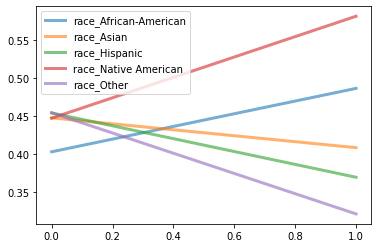

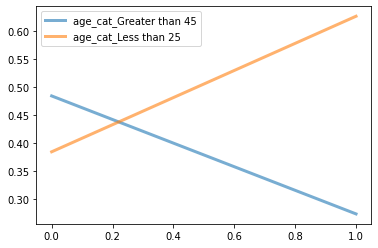

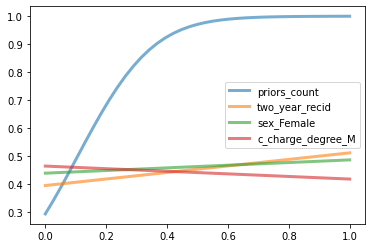

<Figure size 1440x360 with 0 Axes>

In [163]:
def plot_params(vals_dict, prefix = False):
    labels = []
    
    if prefix: # dersom en prefiks oppgis,
        for param, vals in vals_dict.items():
            # print(param)
            if param.startswith(prefix): # plotter vi parametre som har denne prefiksen
                plt.plot(vals[0], vals[1], alpha = 0.6, lw = 3)
                labels.append(param)
    
    else: # dersom prefiks ikke oppgis,  
        for param in ['priors_count', 'two_year_recid', 'sex_Female', 'c_charge_degree_M']:
                plt.plot(vals_dict[param][0], vals_dict[param][1], alpha = 0.6, lw = 3)
                labels.append(param)

    plt.legend(labels)
    plt.show()

plot_params(z_vals, "race") # plotter de ulike parameterkategoriene hver for segs(z_vals, "age_cat")
plot_params(z_vals, "age_cat")
plot_params(z_vals) # plotter 
plt.gcf().set_size_inches(20, 5)

In [ ]:
#Ny celle